## 1. Imports

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
from sentence_transformers import SentenceTransformer

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, concatenate,Lambda,Dot
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.regularizers import l2


import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2. Data Preprocessing

### 2.1 Data Loading

In [113]:
def load_data(file_path, func_type='train'):
    with open(file_path, 'r') as f:
        data = json.load(f)

    prompts, responses, metric_names, scores = [], [], [], []
    for item in data:
        prompt = item['user_prompt']
        sys_prompt = item['system_prompt']
        response = item['response']
        metric_name = item['metric_name']

        if sys_prompt is None:
            sys_prompt = ""
        text = prompt + " " + sys_prompt

        if func_type == 'train':
            scores.append(float(item['score']))

        prompts.append(text)
        responses.append(response)
        metric_names.append(metric_name)

    if func_type == 'train':
        df = pd.DataFrame({
            'prompt': prompts,
            'response': responses,
            'metric_name': metric_names,
            'score': scores
        })
    else:
        df = pd.DataFrame({
            'prompt': prompts,
            'response': responses,
            'metric_name': metric_names
        })
    return df

In [114]:
train_df = load_data('data/train_data.json', 'train')
test_df = load_data('data/test_data.json', 'test')

### 2.2 Class Imbalance

In [115]:
train_df['score'].value_counts()

score
9.0     3123
10.0    1442
8.0      259
7.0       95
6.0       45
0.0       13
3.0        7
1.0        6
2.0        5
4.0        3
5.0        1
9.5        1
Name: count, dtype: int64

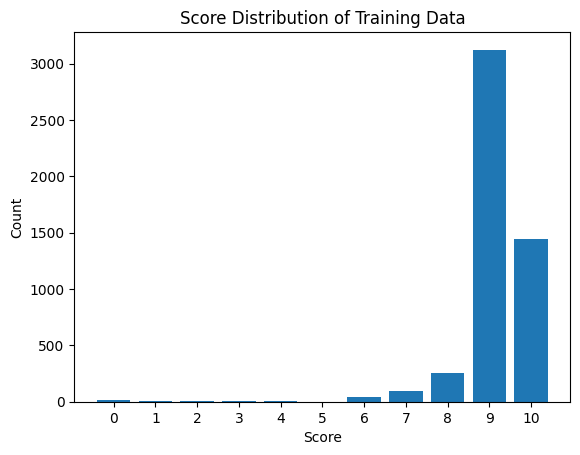

In [116]:
plt.bar(train_df['score'].value_counts().index, train_df['score'].value_counts().values)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Score Distribution of Training Data')
plt.xticks(range(0, 11))
plt.show()



In [5]:
train_df = train_df[train_df['score'] != 9.5].reset_index(drop=True)

In [6]:
row_to_duplicate = train_df[train_df['score'] == 5.0]
train_df = pd.concat([train_df, row_to_duplicate], ignore_index=True)

### 2.3 Handling null Values

In [7]:
train_df.isnull().sum()


prompt         0
response       1
metric_name    0
score          0
dtype: int64

In [8]:
train_df.dropna(inplace=True)

In [9]:
train_df.isnull().sum()


prompt         0
response       0
metric_name    0
score          0
dtype: int64

### 2.4 Load Embeddings

### 2.4.1 Load Metric Embeddings

In [10]:
def get_metric_embeddings(metric_path, embed_path):
    embed_matrix = np.load(embed_path)
    with open(metric_path, 'r') as f:
        metrics = json.load(f)
    return {metrics[i]: embed_matrix[i] for i in range(len(metrics))}


In [11]:
metric_path = 'data/metric_names.json'
embed_path = 'data/metric_name_embeddings.npy'

metric_embed_map = get_metric_embeddings(metric_path, embed_path)


### 2.4.2 Load Prompt And Response Embeddings

In [12]:
def embedding_generation(df):
    embed_model = SentenceTransformer("l3cube-pune/indic-sentence-bert-nli")
    prompt_list = df['prompt'].tolist()
    response_list = df['response'].tolist()

    prompt_embeds = embed_model.encode(prompt_list, convert_to_numpy=True, show_progress_bar=True)
    response_embeds = embed_model.encode(response_list, convert_to_numpy=True, show_progress_bar=True)

    return prompt_embeds, response_embeds


### !!! Uncomment if you are running for first time

In [ ]:
# os.makedirs('embeddings', exist_ok=True)

# train_prompt_embeddings, train_response_embeddings = embedding_generation(train_df)
# test_prompt_embeddings, test_response_embeddings = embedding_generation(test_df)

# np.save('embeddings/train_prompt_embeddings.npy', train_prompt_embeddings)
# np.save('embeddings/train_response_embeddings.npy', train_response_embeddings)
# np.save('embeddings/test_prompt_embeddings.npy', test_prompt_embeddings)
# np.save('embeddings/test_response_embeddings.npy', test_response_embeddings)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

In [14]:
train_prompt_embeddings = np.load('embeddings/train_prompt_embeddings.npy')
train_response_embeddings = np.load('embeddings/train_response_embeddings.npy')

test_prompt_embeddings = np.load('embeddings/test_prompt_embeddings.npy')
test_response_embeddings = np.load('embeddings/test_response_embeddings.npy')

## 3 Data Generataion

### 3.1 Metric Similarity

In [15]:
metric_embeddings = np.load('data/metric_name_embeddings.npy')
num_metrics = len(metric_embeddings)
sim_matrix = np.zeros((num_metrics, num_metrics))

for i in range(num_metrics):
    emb_i = metric_embeddings[i]
    for j in range(i, num_metrics):
        emb_j = metric_embeddings[j]
        cos_sim = np.dot(emb_i, emb_j) / (np.linalg.norm(emb_i) * np.linalg.norm(emb_j))
        sim_matrix[i, j] = sim_matrix[j, i] = cos_sim

sim_matrix = (sim_matrix - sim_matrix.min()) / (sim_matrix.max() - sim_matrix.min())
sim_matrix = np.round(sim_matrix, 1)

In [16]:
score_cnts = train_df['score'].value_counts()


### 3.2 Data Generation to Counter Class Imbalanced

In [17]:

y = train_df['score'].values
indices = np.arange(len(y))
train_indices, val_indices = train_test_split(
    indices,
    test_size=0.3,
    random_state=42,
    stratify=y.round()
)

gen_data_df = train_df.iloc[train_indices].reset_index(drop=True)
val_data_df = train_df.iloc[val_indices].reset_index(drop=True)

y_train = gen_data_df['score'].values
y_val = val_data_df['score'].values

In [18]:
def generate_synthetic_data(train_df, sim_matrix, metric_embed_map, target=4000):
    keys = list(metric_embed_map.keys())

    syn_data = []
    y = train_df['score'].values
    score_cnts = train_df['score'].round().value_counts().to_dict()

    for k in range(11):
        score_cnts.setdefault(k, 0)

    max_passes = 5

    for _ in range(max_passes):

        new_samples = 0

        for i in range(len(y)):
            if y[i] < 9:
                continue

            metric_name = train_df.iloc[i]['metric_name']
            metric_idx = keys.index(metric_name)
            sim_row = sim_matrix[metric_idx]

            score_zones = {k: [] for k in range(11)}
            for j in range(len(keys)):
                sim_value = sim_row[j]
                sim_bin = int(np.clip(round(sim_value * 10), 0, 10))
                score_zones[sim_bin].append(j)

            prompt = train_df.iloc[i]['prompt']
            response = train_df.iloc[i]['response']

            new_added = 0
            max_new_per_seed = 30

            for j in range(11):
                if score_cnts[j] >= target:
                    continue

                candidates = score_zones[j]
                if len(candidates) == 0:
                    continue

                num_to_sample = min(5, target - score_cnts[j], len(candidates))
                selected_idxs = np.random.choice(candidates, size=num_to_sample, replace=False)

                for target_idx in selected_idxs:
                    target_metric = keys[target_idx]
                    sim_value = sim_row[target_idx]
                    pseudo_score = sim_value * 10 + np.random.uniform(-0.3, 0.3)
                    pseudo_score = float(np.clip(pseudo_score, 0, 10))
                    score_bin = int(round(pseudo_score))

                    if score_cnts[score_bin] >= target:
                        continue

                    syn_data.append({
                        "metric_name": target_metric,
                        "prompt": prompt,
                        "response": response,
                        "score": score_bin
                    })
                    score_cnts[score_bin] += 1
                    new_samples += 1
                    new_added += 1

                    if new_added >= max_new_per_seed:
                        break

            if all(v >= target for v in score_cnts.values()):
                break

        if new_samples == 0:
            break

        if all(v >= target for v in score_cnts.values()):
            break

    return pd.DataFrame(syn_data)


In [19]:
syn_df = generate_synthetic_data(gen_data_df, sim_matrix, metric_embed_map, target=4000)
gen_data_df = pd.concat([gen_data_df, syn_df], ignore_index=True)

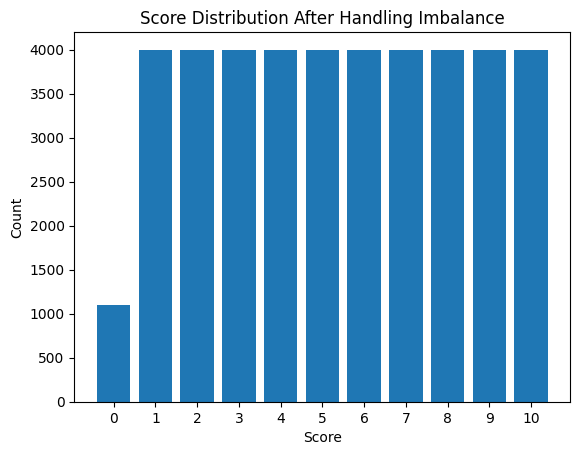

In [117]:
plt.bar(gen_data_df['score'].value_counts().index, gen_data_df['score'].value_counts().values)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Score Distribution After Handling Imbalance')
plt.xticks(range(0, 11))
plt.show()



### 3.3 Regenrate Prompt And Response Embeddings For Training Data

### !!! Uncomment if you are running for first time

In [ ]:
# os.makedirs('embeddings', exist_ok=True)

# gen_prompt_embeddings, gen_response_embeddings = embedding_generation(gen_data_df)

# np.save('embeddings/gen_prompt_embeddings.npy', gen_prompt_embeddings )
# np.save('embeddings/gen_response_embeddings.npy', gen_response_embeddings)

# print("Saved train embeddings shapes:", gen_prompt_embeddings.shape, gen_response_embeddings.shape)


Batches:   0%|          | 0/1285 [00:00<?, ?it/s]

Batches:   0%|          | 0/1285 [00:00<?, ?it/s]

Saved train embeddings shapes: (41104, 768) (41104, 768)


In [21]:
gen_prompt_embeddings = np.load('embeddings/gen_prompt_embeddings.npy')
gen_response_embeddings = np.load('embeddings/gen_response_embeddings.npy')

### 3.4 Feature Preparation

In [22]:
def prepare_features(df, prompt_embeds, response_embeds):
    metric_embeds, pair_embeds = [], []
    for i in range(len(df)):
        m = metric_embed_map[df.iloc[i]['metric_name']]
        p = prompt_embeds[i]
        r = response_embeds[i]
        pair = np.concatenate([p, r])
        metric_embeds.append(m)
        pair_embeds.append(pair)
    return np.array(metric_embeds), np.array(pair_embeds)


In [23]:
X_train_metric, X_train_pair = prepare_features(gen_data_df, gen_prompt_embeddings, gen_response_embeddings)
X_val_metric, X_val_pair = prepare_features(val_data_df, train_prompt_embeddings[val_indices], train_response_embeddings[val_indices])
X_test_metric, X_test_pair = prepare_features(test_df, test_prompt_embeddings, test_response_embeddings)

## 4 Model Building And Training

### 4.1 Model Building

In [92]:
reg = l2(1e-2)

In [93]:
def create_siamesse_model(input_dim_metric, input_dim_pair):
    input_metric = Input(shape=(input_dim_metric,), name='metric_input')
    input_pair = Input(shape=(input_dim_pair,), name='pair_input')

    x_metric = Dense(512, activation='relu',kernel_regularizer=reg)(input_metric)
    x_metric = BatchNormalization()(x_metric)
    x_metric = Dropout(0.3)(x_metric)
    x_metric = Dense(256, activation='relu',kernel_regularizer=reg)(x_metric)

    x_pair = Dense(1024, activation='relu',kernel_regularizer=reg)(input_pair)
    x_pair = BatchNormalization()(x_pair)
    x_pair = Dropout(0.3)(x_pair)
    x_pair = Dense(512, activation='relu',kernel_regularizer=reg)(x_pair)
    x_pair = BatchNormalization()(x_pair)
    x_pair = Dropout(0.3)(x_pair)
    x_pair = Dense(256, activation='relu',kernel_regularizer=reg)(x_pair)

    cos_sim = Dot(axes=1, normalize=True)([x_metric, x_pair])
    abs_diff = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([x_metric, x_pair])

    combined = concatenate([
        x_metric,
        x_pair,
        cos_sim,
        abs_diff
    ])
    
    x = Dense(256, activation='relu',kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(128, activation='relu',kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)


    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[input_metric, input_pair], outputs=output)

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss=Huber(delta=0.8),
                  metrics=[RootMeanSquaredError(), 'mae'])

    return model

In [94]:

es = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)

In [95]:
model = create_siamesse_model(X_train_metric.shape[1], X_train_pair.shape[1])

In [96]:
y_train = gen_data_df['score'].values
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))



In [97]:
history = model.fit(
    [X_train_metric, X_train_pair],
    y_train,
    validation_data=([X_val_metric, X_val_pair], y_val), 
    epochs=200,
    batch_size=32,
    class_weight = class_weight_dict,
    callbacks=[es],
    verbose=1
)

Epoch 1/200
1285/1285 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - loss: 32.1807 - mae: 4.4251 - root_mean_squared_error: 5.3184 - val_loss: 26.9047 - val_mae: 6.0462 - val_root_mean_squared_error: 6.2434
Epoch 2/200
1285/1285 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 19.5612 - mae: 2.5845 - root_mean_squared_error: 3.3400 - val_loss: 16.1881 - val_mae: 3.0848 - val_root_mean_squared_error: 3.4931
Epoch 3/200
1285/1285 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 12.5929 - mae: 2.0534 - root_mean_squared_error: 2.6150 - val_loss: 10.1494 - val_mae: 1.9534 - val_root_mean_squared_error: 2.4571
Epoch 4/200
1285/1285 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 8.3223 - mae: 1.8947 - root_mean_squared_error: 2.4216 - val_loss: 6.9214 - val_mae: 1.9778 - val_root_mean_squared_error: 2.4159
Epoch 5/200
1285/1285 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 5.6787 - mae: 1.7645 - root_mean_squared_error: 2.2684 - val_loss: 4.9423 - val_mae: 1.9281 - val_root_mean_squared_error: 2.3469
Epoch 6/200
1285/1285 ━━━━━

### 4.2 Validation

In [98]:
val_preds = model.predict([X_val_metric, X_val_pair]).flatten()
val_preds = np.clip(val_preds, 0, 10)

mae = mean_absolute_error(y_val, val_preds)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))

print(f"MAE : {mae:.4f},  RMSE: {rmse:.4f}")




47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
MAE : 1.0332,  RMSE: 1.5721


### 4.3 Test Predictions

In [100]:
test_preds = model.predict([X_test_metric, X_test_pair]).flatten()

test_preds = np.clip(test_preds, 0, 10)
test_preds = np.round(test_preds)

submission = pd.DataFrame({
    'ID': np.arange(1,len(test_preds)+1),
    'Score': test_preds
})
submission.to_csv('submission.csv', index=False)
print("\nSaved submission as 'submission.csv'")
# print(submission.head())




114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Saved submission as 'submission.csv'


## 5 Creating Train And Validation Tables

In [101]:
history_df = pd.DataFrame(history.history)  
history_df

,loss,mae,root_mean_squared_error,val_loss,val_mae,val_root_mean_squared_error
0,32.180717,4.425141,5.318423,26.904694,6.046160,6.243439
1,19.561234,2.584491,3.340020,16.188082,3.084755,3.493072
2,12.592932,2.053425,2.615036,10.149393,1.953353,2.457072
3,8.322328,1.894683,2.421629,6.921368,1.977801,2.415868
4,5.678709,1.764486,2.268350,4.942336,1.928147,2.346925
5,4.097882,1.681422,2.164215,3.776867,1.939878,2.409738
6,3.079900,1.593296,2.071515,2.911197,1.790819,2.279918
7,2.408440,1.509625,1.973462,2.411597,1.784666,2.210128
8,1.956251,1.448901,1.895899,1.861346,1.492787,1.962491
9,1.637756,1.396261,1.839148,1.560857,1.402597,1.871076


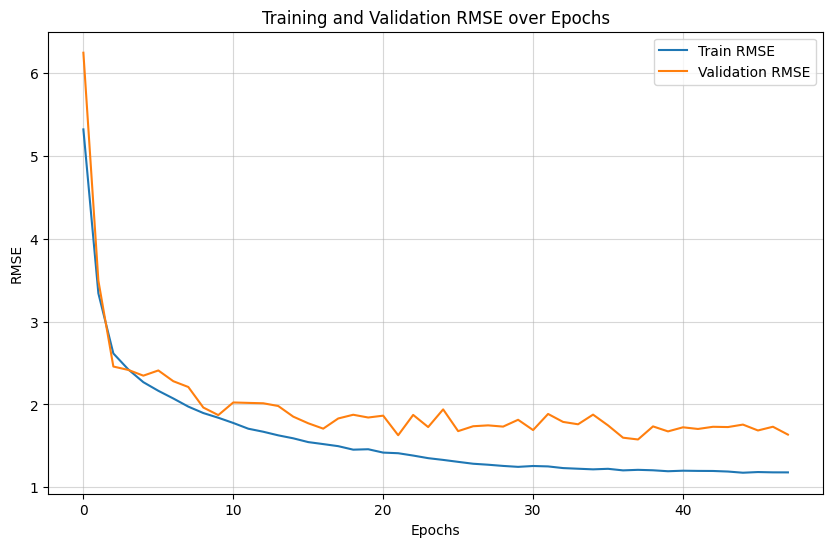

In [105]:
val_rmse = history_df['val_root_mean_squared_error']
train_rmse = history_df['root_mean_squared_error']

plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE over Epochs')
plt.legend()
plt.grid(alpha=0.5)
plt.show()